# Recurren NN

In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from d2l import torch as d2l
from torch.nn import functional as F

## Data series

Here, our 1000 synthetic data will follow the trigonometric sin function, applied to 0.01 times the time step. To make the problem a little more interesting, we corrupt each sample with additive noise. From this sequence we extract training examples, each consisting of features and a label.

In [2]:
class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        self.save_hyperparameters()
        # Generate the time series data
        self.time = torch.arange(1, T + 1, dtype=torch.float32)
        # Generate the input features as sin(0.01 * time) + some noise
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2

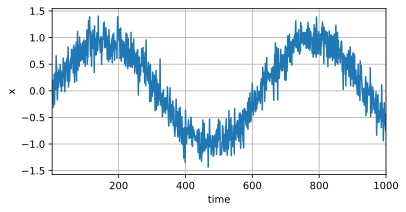

In [3]:
data = Data()
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

To begin, we try a model that acts as if the data satisfied a 𝜏$^{th}$-order Markov condition (tau is 4 by default), and thus predicts 𝑥$_𝑡$ using only the past 𝜏 observations.

We create a data iterator on the first 600 examples, covering a period of the sin function.

In this example our model will be a standard linear regression.

In [4]:
@d2l.add_to_class(Data)
def get_dataloader(self, train):
    # By default, tau=4, T=1000 so we create features using the past 4 observations for each time step
    # and predict the next observation.
    # this line creates a list of tensors, where each tensor corresponds to a time-lagged version of the original time series.
    # For example, if tau=4, it creates 4 tensors:
    # - The first tensor contains all elements from index 0 to T-4 (i.e., x[0], x[1], ..., x[T-4])
    # - The second tensor contains all elements from index 1 to T-3 (i.e., x[1], x[2], ..., x[T-3])
    # - The third tensor contains all elements from index 2 to T-2 (i.e., x[2], x[3], ..., x[T-2])
    # - The fourth tensor contains all elements from index 3 to T-1 (i.e., x[3], x[4], ..., x[T-1])
    features = [self.x[i : self.T-self.tau+i] for i in range(self.tau)]
    # Stack these tensors along a new dimension (dimension 1) to create a 2D tensor with the tau features as columns.
    self.features = torch.stack(features, 1)
    # the labels are the values of the time series starting from index tau to the end
    self.labels = self.x[self.tau:].reshape((-1, 1))
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    # slice(start, stop) is used to define a slice object, which can be used to 
    # index arrays like array[slice_obj] instead of array[start:stop]. 
    # If train is True, then i = slice(0, self.num_train) 
    # selects the training set (from index 0 to self.num_train - 1).
    # If train is False, then i = slice(self.num_train, None)
    # selects the validation/test set (from self.num_train to the end of the array).
    return self.get_tensorloader([self.features, self.labels], train, i)

## Autoregressive Model

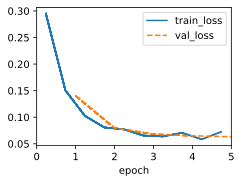

In [5]:
model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

To evaluate our model, we first check how well it performs at one-step-ahead prediction.

Remember that we only trin on the first 600 windows.

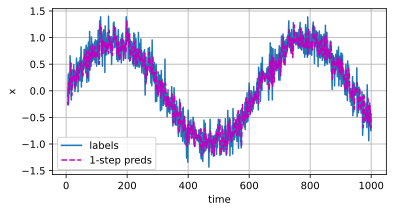

In [6]:
onestep_preds = model(data.features).detach().numpy()
# we evaluate the model on the entire dataset: even if we only trained on the first 600 windows, 
# we can still make predictions for the entire series once we see the new data t predict the next value.
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x',
         legend=['labels', '1-step preds'], figsize=(6, 3))

These predictions look good, even near the end at 𝑡 = 1000. 

But what if we only observed sequence data up until time step 604 (n_train + tau) and wished to make predictions several steps into the future? 

We can address this problem by plugging in our earlier predictions as inputs to our model for making subsequent predictions, projecting forward, one step at a time, until reaching the desired time step.  In other words, we will have to keep on using our own predictions to make multistep-ahead predictions. 

Generally, for an observed sequence 𝑥$_1$, . . . , 𝑥$_𝑡$ , its predicted output 𝑥$_{𝑡+𝑘}$ at time step 𝑡 + 𝑘 is called the 𝑘-step-ahead prediction.






In [7]:
multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x
for i in range(data.num_train + data.tau, data.T): # these are the indices we want to predict which we did not train on
    # We substitute the previous true values with our own predictions
    multistep_preds[i] = model(multistep_preds[i - data.tau:i].reshape((1, -1)))
multistep_preds = multistep_preds.detach().numpy()

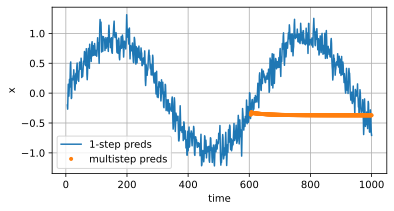

In [8]:
d2l.plot([data.time[data.tau:], data.time[data.num_train+data.tau:]],
         [onestep_preds, multistep_preds[data.num_train+data.tau:]], 
         'time','x', legend=['1-step preds', 'multistep preds'], figsize=(6, 3), fmts=('-', '.'))

Unfortunately, in this case we fail spectacularly.

Ultimately, this is down to the fact that errors build up. We are familiar with this common phenomenon. For instance, weather forecasts for the next 24 hours tend to be pretty accurate but beyond that, accuracy declines rapidly. 

Let’s take a closer look at the difficulties in 𝑘-step-ahead predictions by computing predictions on the entire sequence for 𝑘 = 1, 4, 16, 64.

In [9]:
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i+data.T-data.tau-k+1])
    # The (i+tau)-th element stores the (i+1)-step-ahead predictions
    for i in range(k):
        preds = model(torch.stack(features[i : i+data.tau], 1))
        features.append(preds.reshape(-1))
    return features[data.tau:]

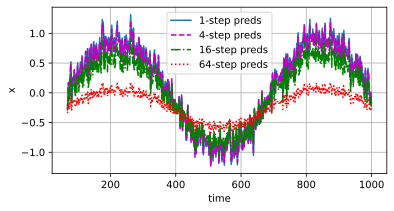

In [10]:
steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
d2l.plot(data.time[data.tau+steps[-1]-1:],
         [preds[k - 1].detach().numpy() for k in steps], 'time', 'x',
         legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))

This clearly illustrates how the quality of the prediction changes as we try to predict further into the future. While the 4-step-ahead predictions still look good, anything beyond that is almost useless.

# Converting Raw Text into Sequence Data (check this out on your own)

Here, we will work with H. G. Wells’ The Time Machine 137 , a book containing just over 30,000 words. While real applications will typically involve significantly larger datasets, this is sufficient to demonstrate the preprocessing pipeline. The following _download method reads the raw text into a string.

In [29]:
import collections
import random
import re

In [30]:
class TimeMachine(d2l.DataModule): #@save
    """The Time Machine dataset."""
    def _download(self):
        fname = d2l.download(d2l.DATA_URL + 'timemachine.txt', self.root,
                             '090b5e7e70c295757f55df93cb0a180b9691891a')
        with open(fname) as f:
            return f.read()
        
data = TimeMachine()
raw_text = data._download()
raw_text[:60]

'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Tra'

For simplicity, we ignore punctuation and capitalization when preprocessing the raw text.

In [31]:
@d2l.add_to_class(TimeMachine)  #@save
def _preprocess(self, text):
    return re.sub('[^A-Za-z]+', ' ', text).lower()

text = data._preprocess(raw_text)
text[:60]

'the time machine by h g wells i the time traveller for so it'

## Tokens

Tokens are the atomic (indivisible) units of text. Each time step corresponds to 1 token, but what precisely constitutes a token is a design choice. 

For example, we could represent the sentence “Baby needs a new pair of shoes” as a sequence of 7 words, where the set of all words comprise a large vocabulary (typically tens or hundreds of thousands of words). Or we would represent the same sentence as a much longer sequence of 30 characters, using a much smaller vocabulary (there are only 256 distinct ASCII characters). 

In [33]:
# tokenize by character:

@d2l.add_to_class(TimeMachine)  #@save
def _tokenize(self, text):
    return list(text)


tokens = data._tokenize(text)
','.join(tokens[:30])

't,h,e, ,t,i,m,e, ,m,a,c,h,i,n,e, ,b,y, ,h, ,g, ,w,e,l,l,s, '

## Vocabulary

These tokens are still strings. However, the inputs to our models must ultimately consist of numerical inputs. 

Next, we introduce a class for constructing vocabularies, i.e., objects that associate each distinct token value with a unique index: 
- First, we determine the set of unique tokens in our training corpus. 
- We then assign a numerical index to each unique token. 
- Rare vocabulary elements are often dropped for convenience. Whenever we encounter a token at training or test time that had not been previously seen or was dropped from the vocabulary, we represent it by a special `“<unk>”` token, signifying that this is an unknown value.

In [34]:
class Vocab:  #@save
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
    def __len__(self):
        return len(self.idx_to_token)
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]
    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']


In [36]:
vocab = Vocab(tokens)
indices = vocab[tokens[:10]]
print('indices:', indices)
print('letters:', vocab.to_tokens(indices))

indices: [21, 9, 6, 0, 21, 10, 14, 6, 0, 14]
letters: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']


## Putting It All Together

Using the above classes and methods, we package everything into the following build method of the `TimeMachine` class, which returns _corpus_, a list of token indices, and _vocab_, the vocabulary of _The Time Machine_ corpus. The modifications we did here are: 
- we tokenize text into characters, not words, to simplify the training in later sections; 
- _corpus_ is a single list, not a list of token lists, since each text line in The Time Machine dataset is not necessarily a sentence or paragraph.

In [38]:
@d2l.add_to_class(TimeMachine)  #@save
def build(self, raw_text, vocab=None):
    tokens = self._tokenize(self._preprocess(raw_text))
    if vocab is None: vocab = Vocab(tokens)
    corpus = [vocab[token] for token in tokens]
    return corpus, vocab

# count the  number of characters in the text and the size of the vocabulary
corpus, vocab = data.build(raw_text)
len(corpus), len(vocab)

(173428, 28)

## Exploratory Language Statistics

Using the real corpus and the Vocab class defined over words, we can inspect basic statistics concerning word use in our corpus. 

Below, we construct a vocabulary from words used in The Time Machine and print the ten most frequently occurring of them.

In [39]:
words = text.split()
vocab = Vocab(words)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

Note that the ten most frequent words are not all that descriptive (often called _stop words_). 

You might even imagine that we might see a very similar list if we had chosen any book at random.

Note: Word frequency tends to follow a power law distribution (specifically the Zipfian) as we go down the ranks. 

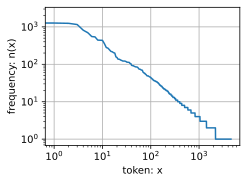

In [57]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

Let’s see whether the bigram frequency behaves in the same manner as the single word (unigram) frequency.

In [41]:
bigram_tokens = ['--'.join(pair) for pair in zip(words[:-1], words[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[('of--the', 309),
 ('in--the', 169),
 ('i--had', 130),
 ('i--was', 112),
 ('and--the', 109),
 ('the--time', 102),
 ('it--was', 99),
 ('to--the', 85),
 ('as--i', 78),
 ('of--a', 73)]

and the trigram frequency:

In [42]:
trigram_tokens = ['--'.join(triple) for triple in zip(
    words[:-2], words[1:-1], words[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[('the--time--traveller', 59),
 ('the--time--machine', 30),
 ('the--medical--man', 24),
 ('it--seemed--to', 16),
 ('it--was--a', 15),
 ('here--and--there', 15),
 ('seemed--to--me', 14),
 ('i--did--not', 14),
 ('i--saw--the', 13),
 ('i--began--to', 13)]

/var/folders/c_/m9xq6z1d7ng4l884vymz4c240000gq/T/ipykernel_77279/198945074.py:7: RuntimeWarning: overflow encountered in power
  return a * x ** (-b)
/var/folders/c_/m9xq6z1d7ng4l884vymz4c240000gq/T/ipykernel_77279/198945074.py:7: RuntimeWarning: overflow encountered in multiply
  return a * x ** (-b)


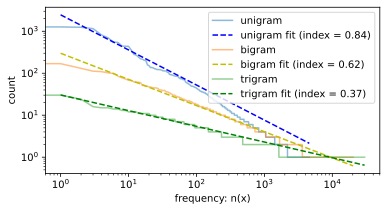

In [65]:
mono_freqs = [freq for token, freq in vocab.token_freqs]
bi_freqs = [freq for token, freq in bigram_vocab.token_freqs]
tri_freqs = [freq for token, freq in trigram_vocab.token_freqs]

# define a power law
def power_law(x, a, b):
    return a * x ** (-b)

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit 

# Fit the power law to the unigram frequencies
mono_x = np.arange(1, len(mono_freqs) + 1)
mono_popt, monopcov = curve_fit(power_law, mono_x, mono_freqs)
bi_x = np.arange(1, len(bi_freqs) + 1)
bi_popt, bipcov = curve_fit(power_law, bi_x, bi_freqs)
tri_x = np.arange(1, len(tri_freqs) + 1)
tri_popt, tripcov = curve_fit(power_law, tri_x, tri_freqs)


plt.figure(figsize=(6, 3))
plt.plot(mono_freqs, alpha=0.5, label='unigram')
plt.plot(mono_x, power_law(mono_x, *mono_popt), 'b--', label=f'unigram fit (index = {mono_popt[1]:.2f})')
plt.plot(bi_freqs, alpha=0.5, label='bigram')
plt.plot(bi_x, power_law(bi_x, *bi_popt), 'y--', label=f'bigram fit (index = {bi_popt[1]:.2f})')
plt.plot(tri_freqs, alpha=0.5, label='trigram')
plt.plot(tri_x, power_law(tri_x, *tri_popt), 'g--', label=f'trigram fit (index = {tri_popt[1]:.2f})')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('frequency: n(x)')
plt.ylabel('count')
plt.legend()
plt.show()


Note how the power-law exponent increases as we move from unigrams to bigrams to trigrams, indicating that higher-order n-grams have a steeper frequency distribution.

This also mean that it becomes more difficult to predict the next token as we increase the n-gram size as the frequency of occurrence of higher-order n-grams decreases more rapidly.

## Language model and _perplexity_

The goal of language models is to estimate the joint probability of the whole sequence $P(x_1, x_2, ..., x_T)$.

An ideal language model should generate natural text on its own, simply by drawing one token at a time 𝑥𝑡 ∼ $𝑃(𝑥_𝑡 | 𝑥_{𝑡−1},...,𝑥_{1})$.

For example, the probability of a text sequence containing four words would be given as:

`𝑃(deep, learning, is, fun) = 𝑃(deep)𝑃(learning | deep)𝑃(is | deep, learning)𝑃(fun | deep, learning, is). `

A good language model should be able to perfectly predict what token comes next in a sequence based on the preceding tokens.

A way to evaluate a language model is to compute the _perplexity_ of the model on a test set. Information theory comes in handy here

### Perplexity

Perplexity is a standard metric for evaluating language models. It quantifies how well a model predicts a sequence of words — **lower values indicate better predictions**.  
Given a test set of $N$ tokens with true words  $w_1, w_2, \ldots, w_N $ and model-predicted probabilities $Q(w_i)$, the perplexity is defined as:


$$\text{Perplexity}(Q) = \exp\left(-\frac{1}{N} \sum_{i=1}^{N} \log Q(w_i)\right)$$


Intuitively, perplexity is the **exponential of the average negative log-likelihood** (it should remind you of the **Entropy**).  
It measures how “surprised” the model is by the true data:  
- A perplexity of $p$ means the model is as uncertain as if it were choosing uniformly among $p$ possible next words.  
- A **lower perplexity** means the model assigns higher probability to the observed text and produces more fluent, accurate predictions.
- In the best case scenario, the model always perfectly estimates the probability of the target token as 1.   In this case the perplexity of the model is 1.
- In the worst case scenario, the model always predicts the probability of the target token as 0. In this situation, the perplexity is positive infinity.
- At the baseline,the model predicts a uniform distribution over all the available tokens of the vocabulary. In this case, the perplexity equals the number of unique tokens of the vocabulary. 


## Partitioning sequences

For language modeling, the goal is to predict the next token based on the tokens we have seen so far; hence the targets (labels) are the original sequence, shifted by one token.

In [ ]:
@d2l.add_to_class(d2l.TimeMachine)  #@save
def __init__(self, batch_size, num_steps, num_train=10000, num_val=5000):
    super(d2l.TimeMachine, self).__init__()
    self.save_hyperparameters()
    corpus, self.vocab = self.build(self._download())
    array = torch.tensor([corpus[i:i+num_steps+1]
                        for i in range(len(corpus)-num_steps)])
    self.X, self.Y = array[:,:-1], array[:,1:]

To train language models, we will randomly sample pairs of input sequences and target sequences in minibatches. The following data loader randomly generates a minibatch from the dataset each time. The argument `batch_size` specifies the number of subsequence examples in each minibatch and `num_steps` is the subsequence length in tokens.

In [66]:
@d2l.add_to_class(d2l.TimeMachine)  #@save
def get_dataloader(self, train):
    idx = slice(0, self.num_train) if train else slice(
        self.num_train, self.num_train + self.num_val)
    return self.get_tensorloader([self.X, self.Y], train, idx)

In [67]:
data = d2l.TimeMachine(batch_size=2, num_steps=10)
for X, Y in data.train_dataloader():
    print('X:', X, '\nY:', Y)
    break

X: tensor([[14, 22, 20, 21,  0,  3,  6,  0,  6, 25],
        [10, 14,  6, 15, 20, 10, 16, 15, 20,  0]]) 
Y: tensor([[22, 20, 21,  0,  3,  6,  0,  6, 25, 17],
        [14,  6, 15, 20, 10, 16, 15, 20,  0, 16]])


# RNNs for character-level language model

<center>
<img src="../images/18_Image_1.png" width="800">

Figure 1: A character-level language model based on the RNN. The input and target sequences are “machin” and “achine”, respectively.
</center>

We will implement an RNN from scratch and we will train this RNN to function as a character-level language model (see Section 9.4) and train it on a Recurrent Neural Network Implementation from Scratch corpus consisting of the entire text of H. G. Wells’ The Time Machine

In [68]:
class RNNScratch(d2l.Module):  #@save
    """The RNN model implemented from scratch."""
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W_xh = nn.Parameter(
            torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(
            torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))

The forward method below defines how to compute the output and hidden state at any time step, given the current input and the state of the model at the previous time step.

Note that the RNN model loops through the outermost dimension of inputs, updating the hidden state one time step at a time.

The model here uses a tanh activation function.

In [ ]:
@d2l.add_to_class(RNNScratch)  #@save
def forward(self, inputs, state=None):
    if state is None:
        # Initial state with shape: (batch_size, num_hiddens = num of letters considered in each example)
        # Note: this is initialized to zeros at every time step
        state = torch.zeros((inputs.shape[1], self.num_hiddens),
                          device=inputs.device)
    else:
        state, = state # This unwraps a single-element tuple or list: eg. state = (42,) -> state = 42
    outputs = []
    for X in inputs:  # Shape of inputs: (num_steps, batch_size, num_inputs)
        state = torch.tanh(torch.matmul(X, self.W_xh) +
                         torch.matmul(state, self.W_hh) + self.b_h)
        outputs.append(state)
    return outputs, state


We can feed a minibatch of input sequences into an RNN model as follows.

In [71]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)

X = torch.ones((num_steps, batch_size, num_inputs))
outputs, state = rnn(X)


Let’s check whether the RNN model produces results of the correct shapes to ensure that the dimensionality of the hidden state remains unchanged.

In [82]:
def check_len(a, n):  #@save
    """Check the length of a list."""
    assert len(a) == n, f'list\'s length {len(a)} != expected length {n}'
    
def check_shape(a, shape):  #@save
    """Check the shape of a tensor."""
    assert a.shape == shape, \
            f'tensor\'s shape {a.shape} != expected shape {shape}'
    
print(outputs[0].shape, outputs[:2])
check_len(outputs, num_steps)
check_shape(outputs[0], (batch_size, num_hiddens))
check_shape(state, (batch_size, num_hiddens))

torch.Size([2, 32]) [tensor([[ 0.0563,  0.0168,  0.0100, -0.0016, -0.0398,  0.0725,  0.0124, -0.0196,
         -0.0191,  0.0012, -0.0107, -0.0113, -0.0402,  0.0204, -0.0074,  0.0223,
         -0.0032, -0.0048, -0.0235,  0.0086, -0.0365, -0.0098,  0.0396,  0.0093,
         -0.0098, -0.0350, -0.0334, -0.0232,  0.0112,  0.0506, -0.0292, -0.0503],
        [ 0.0563,  0.0168,  0.0100, -0.0016, -0.0398,  0.0725,  0.0124, -0.0196,
         -0.0191,  0.0012, -0.0107, -0.0113, -0.0402,  0.0204, -0.0074,  0.0223,
         -0.0032, -0.0048, -0.0235,  0.0086, -0.0365, -0.0098,  0.0396,  0.0093,
         -0.0098, -0.0350, -0.0334, -0.0232,  0.0112,  0.0506, -0.0292, -0.0503]],
       grad_fn=<TanhBackward0>), tensor([[ 0.0532,  0.0170,  0.0090, -0.0031, -0.0384,  0.0691,  0.0144, -0.0194,
         -0.0200,  0.0049, -0.0082, -0.0106, -0.0380,  0.0212, -0.0082,  0.0214,
         -0.0053, -0.0070, -0.0237,  0.0076, -0.0360, -0.0112,  0.0389,  0.0090,
         -0.0081, -0.0366, -0.0328, -0.0226,  0.0122

The following RNNLMScratch class defines an RNN-based language model, where we pass in our RNN via the rnn argument of the `__init__` method. 

When training language models, the inputs and outputs are from the same vocabulary. Hence, they have the same dimension, which is equal to the vocabulary size. Note that we use perplexity to evaluate the model. 

In [ ]:
class RNNLMScratch(d2l.Classifier):  #@save
    """The RNN-based language model implemented from scratch."""
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(
            torch.randn(
                self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        # the loss is the log of the cross-entropy loss, so exp(loss) is the perplexity
        self.plot('ppl', torch.exp(l), train=True)
        return l
    
    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=False)

The 45th and 46th words in our vocabulary happen to be “their” and “said”, whose meanings are not remotely similar.

When dealing with such categorical data, the most common strategy is to represent each item by a one-hot encoding 

In [ ]:
@d2l.add_to_class(RNNLMScratch)  #@save
def one_hot(self, X):
    # Output shape we want: (num_steps, batch_size, vocab_size)
    # We transpose X to have shape (batch_size, num_steps) before one-hot encoding
    # This is because PyTorch's one_hot function expects the last dimension to be the class dimension
    # but also we want to loop through the time steps (num_steps) first to store the hidden states at each time step
    return F.one_hot(X.T, self.vocab_size).type(torch.float32)

The minibatches that we sample at each iteration will take the shape `(batch size, number of time steps)`. Once representing each input as a one-hot vector, we can think of each minibatch as a three-dimensional tensor, where the length along the third axis is given by the vocabulary size (len(vocab)). 

We often **transpose the input** so that we will obtain an output of shape `(number of time steps, batch size, vocabulary size)`. This will allow us to loop more conveniently through the outermost dimension for updating hidden states of a minibatch, time step by time step (e.g., in the above forward method).

#### Example: 

Suppose you have:
- batch_size = 2 (two sentences per batch)
- num_time_steps = 4 (each sentence has 4 words)
- vocab_size = 5 (the vocabulary has 5 unique tokens)

Then before one-hot encoding, your minibatch might look like this:
```
[
  [1, 4, 2, 3],   # sentence 1
  [0, 2, 4, 3]    # sentence 2
]
```
After the one-hot encoading this will be:
```
[
  [ [0,1,0,0,0], [0,0,0,1,0], [0,0,1,0,0], [0,0,0,0,1] ],
  [ [1,0,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1] ]
]
```

In many RNN implementations, we transpose this tensor so that time steps come first:
New shape: `(num_time_steps, batch_size, vocab_size) = (4, 2, 5)`

Now the structure looks like this:
```
[
  [ [0,1,0,0,0], [1,0,0,0,0] ],   # t = 1 (batch of 2 vectors)
  [ [0,0,0,1,0], [0,0,1,0,0] ],   # t = 2
  [ [0,0,1,0,0], [0,0,0,1,0] ],   # t = 3
  [ [0,0,0,0,1], [0,0,0,0,1] ]    # t = 4
]
```

In [ ]:
@d2l.add_to_class(RNNLMScratch)  #@save
def output_layer(self, rnn_outputs):
    outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
    return torch.stack(outputs, 1) # we combine the list of outputs into a single tensor

The language model uses a fully connected output layer to transform RNN outputs into token predictions at each time step.

In [ ]:
@d2l.add_to_class(RNNLMScratch)
def forward(self, X, state=None):
    embs = self.one_hot(X) # one-hot encode the input X
    rnn_outputs, _ = self.rnn(embs, state) # get RNN outputs for each time step
    return self.output_layer(rnn_outputs) # return the outputs combined through the output layer

Let’s check whether the forward computation produces outputs with the correct shape.

In [19]:
model = RNNLMScratch(rnn, num_inputs)
outputs = model(torch.ones((batch_size, num_steps), dtype=torch.int64))
check_shape(outputs, (batch_size, num_steps, num_inputs))


 In addition to the passing through the network in the input-to-output direction, inputs at the first time step must pass through a chain of $𝑇$ layers along the time steps in order to influence the output of the model at the final time step. Taking the backwards view, in each iteration, we backpropagate gradients through time, resulting in a chain of matrix-products of length $O(𝑇)$. 

This can result in _numerical instability_, causing the gradients either to explode or vanish, depending on the properties of the weight matrices.

A popular alternative is to adopt a gradient clipping heuristic projecting the gradients g onto a ball of some given radius 𝜃 as follows:

$$\bar{g}\leftarrow min\left(1, \frac{𝜃}{|\bar{g}|}\right) \bar{g}$$

Below we define a method to clip gradients, which is invoked by the `fit_epoch` method of the  `d2l.Trainer` class (see Notebook). Note that when computing the gradient norm, we are concatenating all model parameters, treating them as a single giant parameter vector.

In [ ]:
@d2l.add_to_class(d2l.Trainer)  #@save
def clip_gradients(self, grad_clip_val, model):
    params = [p for p in model.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params)) # L2 norm
    if norm > grad_clip_val: #grad_clip_val is the theta in the formula
        for param in params:
            param.grad[:] *= grad_clip_val / norm # keeps the direction of the gradient but scales it down

Using The Time Machine dataset (`data`), we train a character-level language model (`model`) based on the RNN (`rnn`) implemented from scratch. Note that we first calculate the gradients, then clip them, and finally update the model parameters using the clipped gradients.

#### Here a schematic example

Let’s assume the following example parameters:
- time_steps = 4
- batch_size = 2
- vocab_size = 5
- num_hiddens = 3

```
                 ┌────────────────────────────────────────────────┐
time_steps=4 →   │ X (4, 2, 5)                                    │
                 └────────────────────────────────────────────────┘
                          │
                          ▼
          ┌──────────────────────────────────────────┐
          │ Iterate through time steps t = 0..3      │
          │------------------------------------------│
          │ For each t:                              │
          │   X_t (2, 5)                             │
          │   H_t = tanh(X_t W_xh + H_{t-1} W_hh + b_h)
          │   H_t.shape = (2, 3)                     │
          └──────────────────────────────────────────┘
                          │
                          ▼
     rnn_outputs = [H_0, H_1, H_2, H_3], each (2, 3)
                          │
                          ▼
          ┌──────────────────────────────────────────┐
          │ Fully connected output layer             │
          │------------------------------------------│
          │   For each H_t:                          │
          │       Y_t = H_t W_hq + b_q               │
          │       W_hq.shape = (3, 5)                │
          │       b_q.shape = (5,)                   │
          │   → Y_t.shape = (2, 5)                   │
          └──────────────────────────────────────────┘
                          │
                          ▼
         Stack over time → torch.stack(Y_t, dim=1)
                          │
                          ▼
     ┌────────────────────────────────────────────┐
     │ Final output: Y.shape = (2, 4, 5)          │
     │  batch_size = 2                            │
     │  time_steps = 4                            │
     │  vocab_size = 5                            │
     └────────────────────────────────────────────┘
```

#### Back Propagation Through Time (BPTT):
```
Forward through all time steps 
    X1 -> H1 -> Y1 
    X2 -> H2 -> Y2 
    X3 -> H3 -> Y3 
    …
↓
Compute total loss (sum over all Y_t)
↓
Backprop through time (gradients flow backward through all time steps)
↓
Update all weights once
↓
Move to next batch / next sequence
```

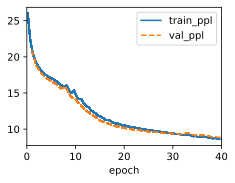

In [104]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=40, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

#### Decoding:
Once a language model has been learned, we can use it not only to predict the next token but to continue predicting each subsequent one, treating the previously predicted token as though it were the next in the input.

It is often useful to condition the language model on a user-supplied `prefix`. For example, if we were developing an **autocomplete feature** for a search engine or to assist users in writing emails, we would want to feed in what they had written so far (the prefix), and then generate a likely continuation.

The following `predict` method generates a continuation, one character at a time, after ingesting a user-provided `prefix`. Looping through the characters in prefix is called the _warm-up period_ (no output is provided). After ingesting the prefix, we are now ready to begin emitting the subsequent characters, each of which will be fed back into the model as the input at the next time step.

In [83]:
@d2l.add_to_class(RNNLMScratch)  #@save
def predict(self, prefix, num_preds, vocab, device=None):
    state, outputs = None, [vocab[prefix[0]]]
    for i in range(len(prefix) + num_preds - 1):
        X = torch.tensor([[outputs[-1]]], device=device)
        embs = self.one_hot(X)
        rnn_outputs, state = self.rnn(embs, state)
        if i < len(prefix) - 1:  # Warm-up period
            outputs.append(vocab[prefix[i + 1]])
        else:  # Predict num_preds steps
            Y = self.output_layer(rnn_outputs)
            outputs.append(int(Y.argmax(axis=2).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In the following, we specify the prefix and have it generate 20 additional characters.

In [103]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has a mones and the the'

## Concise Implementation

In [106]:
class RNN(d2l.Module):  #@save
     """The RNN model implemented with high-level APIs."""
     def __init__(self, num_inputs, num_hiddens):
         super().__init__()
         self.save_hyperparameters()
         self.rnn = nn.RNN(num_inputs, num_hiddens)
     def forward(self, inputs, H=None):
         return self.rnn(inputs, H)

class RNNLM(d2l.RNNLMScratch):  #@save
    """The RNN-based language model implemented with high-level APIs."""
    def init_params(self):
        self.linear = nn.LazyLinear(self.vocab_size)
    def output_layer(self, hiddens):
        return self.linear(hiddens).swapaxes(0, 1)

Before training the model, let’s make a prediction with a model initialized with random weights. 

Given that we have not trained the network, it will generate nonsensical predictions.

In [108]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNN(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLM(rnn, vocab_size=len(data.vocab), lr=1)
model.predict('it has', 20, data.vocab)

'it hasxxccpfcc xxcpfcc xxc'

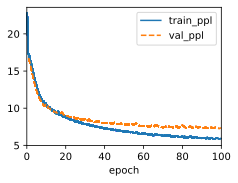

In [109]:
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [111]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has of the the the the '